In [1]:
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
"""
TOP_N = 30
KEYS = { \
    "offensive": set(), 
    "abusive": set(), 
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    "sexism": set(),
    "spam": set(),
    "benevolent": set(),
    "hate_speech": set(),
    "toxic": set(),
    "identity": set()
        
}
FIXED_KEYS = list(KEYS.keys())
"""

'\nTOP_N = 30\nKEYS = {     "offensive": set(), \n    "abusive": set(), \n    "cyberbullying": set(), \n    "vulgar": set(), \n    "racist": set(), \n    "homophobic": set(), \n    "profane": set(), \n    "slur": set(), \n    "harrasment": set(), \n    "obscene": set(), \n    "threat": set(), \n    "discredit": set(), \n    "hateful": set(), \n    "insult": set(), \n    "hostile": set(),\n    "sexism": set(),\n    "spam": set(),\n    "benevolent": set(),\n    "hate_speech": set(),\n    "toxic": set(),\n    "identity": set()\n        \n}\nFIXED_KEYS = list(KEYS.keys())\n'

In [3]:
TOP_N = 20
KEYS = { \
   "peopl": set(),
    "white": set(),
    "terror": set(),
    "feminazi": set(),
    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "douchebag": set(),
    "die": set(),
    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

In [4]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'peopl': {'peopl'},
 'white': {'white'},
 'terror': {'terror'},
 'feminazi': {'feminazi'},
 'women': {'woman', 'women'},
 'sexist': {'sexist'},
 'classy': {'classi', 'classy'},
 'sassy': {'sassi', 'sassy'},
 'nasty': {'nasti', 'nasty'},
 'stupid': {'stupid'},
 'shit': {'shit'},
 'idiot': {'idiot'},
 'trump': {'trump'},
 'nigga': {'nigga'},
 'giveaway': {'giveaway'},
 'game': {'game'},
 'enter': {'enter'},
 'guy': {'guy'},
 'good': {'good'},
 'gone': {'gone'},
 'world': {'world'},
 'fuck': {'fuck'},
 'little': {'littl', 'little'},
 'ass': {'as', 'ass'},
 'bitch': {'bitch'},
 'douchebag': {'douchebag'},
 'die': {'die'},
 'block': {'block'}}

In [5]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [6]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [7]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [8]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [11]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [12]:
model_gn = gensim.downloader.load('word2vec-google-news-300')

KeyboardInterrupt: 

In [45]:
word_clusters_a, embedding_clusters = getSimilarWords(model_gn)

{'peopl'} -- people.i
{'peopl'} -- people
{'white'} -- whites
{'terror'} -- terrorism
{'terror'} -- terrorist
{'terror'} -- terrorists
{'terror'} -- terrorist attacks
{'terror'} -- terror
{'terror'} -- terrorist
{'terror'} -- terrorism
{'terror'} -- counter terrorism
{'terror'} -- terror plots
{'terror'} -- counterterrorism
{'terror'} -- antiterrorism
{'terror'} -- antiterror
{'terror'} -- terror suspects
{'terror'} -- homegrown terrorists
{'feminazi'} -- feminazis
{'women', 'woman'} -- women
{'women', 'woman'} -- womens
{'women', 'woman'} -- transwomen
{'women', 'woman'} -- women
{'women', 'woman'} -- woman
{'women', 'woman'} -- womens
{'women', 'woman'} -- women.the
{'women', 'woman'} -- women's
{'women', 'woman'} -- womenfolk
{'women', 'woman'} -- women's
{'women', 'woman'} -- businesswomen
{'women', 'woman'} -- womenâ € ™
{'women', 'woman'} -- workingwomen
{'sexist'} -- blatantly sexist
{'sexist'} -- racist sexist
{'sexist'} -- sexist
{'sexist'} -- sexists
{'sexist'} -- overtly sex

In [46]:
displayDF(word_clusters_a)

,peopl,white,terror,feminazi,women,sexist,classy,sassy,nasty,stupid,shit,idiot,trump,nigga,giveaway,game,enter,guy,good,gone,world,fuck,little,ass,bitch,douchebag,die,block
0,peop,black,al_Qaeda,commie_pinko,men,misogynistic,stylish,spunky,ugly,dumb,sh_*_t,moron,supersede,n_*_gga,give_aways,play,entry,dude,great,went,globe,f_*_ck,bit,butt,b_*_tch,douche_bag,perish,Exume_tried
1,ppl,blue,Al_Qaeda,whackjob,girls,sexism,elegant,sass,vicious,silly,crap,asshole,supercede,ni_**,giveways,match,participate,kid,bad,go,country,f_**_k,much,azz,ab_****,douche,dying,Kedvale_Avenue
2,peopel,brown,al_Qa'ida,women_libber,females,demeaning,lovely,brassy,unpleasant,idiotic,fucking,imbecile,prevail,n_*_ggas,raffle,matchup,leave,somebody,terrific,goes,continent,shit,wee_bit,shit,ab_*_tch,asshole,oil_Cvitanovich,Terroristic_threat
3,peple,colored,al_Qaida,male_chauvinist_pig,mothers,racist,tasteful,sexy,vile,foolish,sh_t,jackass,outweigh,homie,giveway,opener,join,fella,decent,fallen,nation,f_***,litte,dick,b_****,moron,kill,Hoyne_Avenue
4,poeple,wrote_Newitz,Qaeda,nerd_geek,ladies,misogynist,Stylish,perky,spiteful,ridiculous,fuckin,dumbass,trample,kanye,sweepstakes,matches,register,he'sa,nice,come,global,f_ck,everything'sa,hiney,whore,asshat,starve,Goguac_Street
5,nigerians,gray,Islamic_extremists,chauvinist_pig,husbands,vulgar,flashy,vampy,bad,dumb_dumb,sh_**,dolt,overshadow,motherf_*_cker,freebie,tournament,go,kidder,excellent,gotten,United_States,f_---,lot,dude,b_**_ch,dumbass,succumb,Briarwood_Drive
6,some1,browns_grays,jihadi,harpie,Men,blatant_sexism,nice,bitchy,bitter,moronic,fuck,stupid,dictate,**_ga,Raffle,playing,particpate,bloke,fantastic,done,globally,y'know,maybe,d_*_ck,ab_**_ch,jackass,Fatalistic_kids,Boxwood_Drive
7,peo_ple,blues_grays,al_Qa'eda,Andrea_Dworkin,female,ageist,fabulous,ditzy,wicked,idiots,f_*_cking,buffoon,reign_supreme,sh_*_t,Give_Away,league,engage,Mike'sa,better,moved,America,sh_*_t,tad,nads,bastard,dick,suffer,Avers_Avenue
8,peole,grays_browns,jihadist,libtard,male_counterparts,objectifies_women,gorgeous,sexpot,horrible,childish_immature,y'know,asshat,negate,brotha,Scavenger_hunt,scrimmages,send,involuntarily_yawned,solid,going,Europe,goddamn,litle,**_es,asshole,assclown,death,Woodale_Avenue
9,u_ppl,gorgeously_photographed_black,terrrorism,feminists,teenage_girls,politically_incorrect,sleek,saucy,viscious,daft,shyt,ignoramus,overridden,jay_z,Festive_Frenzy,scrimmage,partake,kid'sa,lousy,disappeared,planet,f_*_cking,smidgen,sh_*_t,whore_slut,twit,leaving_wispy_strands,South_Telshor_Boulevard


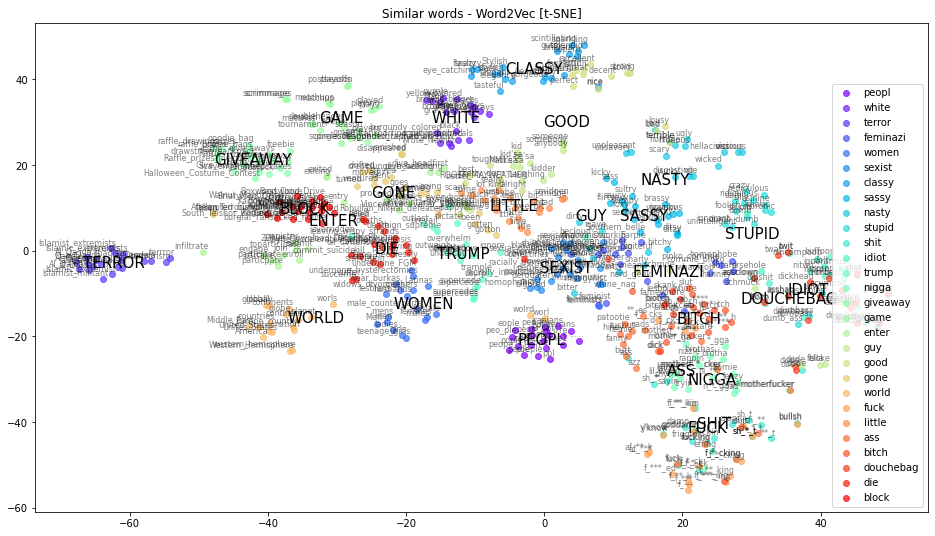

In [47]:
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - t-SNE.png")

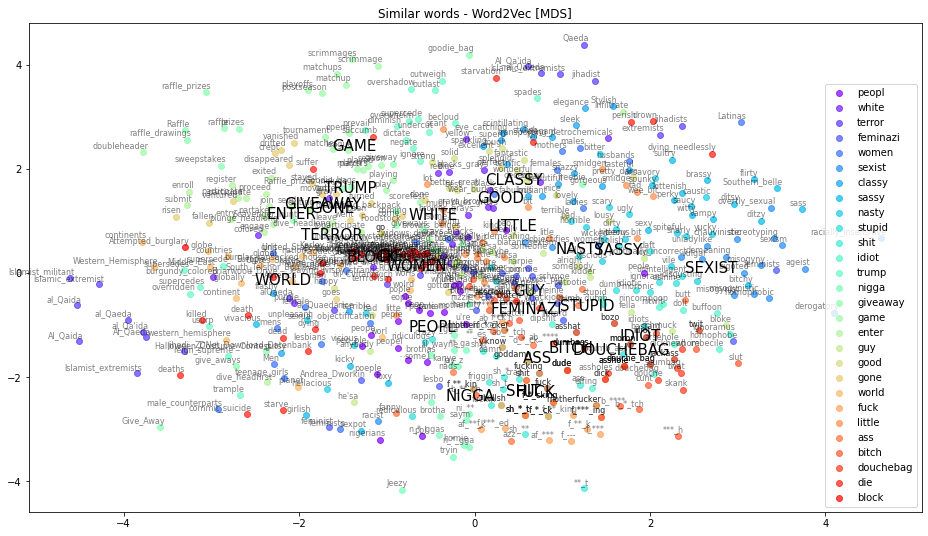

In [48]:
plotMDS("Similar words - Word2Vec [MDS]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - MDS.png")

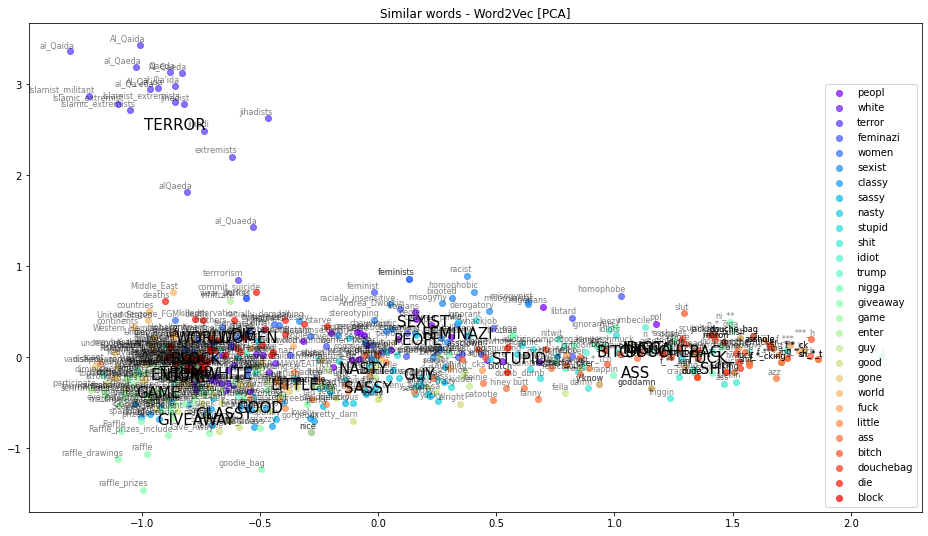

In [49]:
plotPCA("Similar words - Word2Vec [PCA]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - PCA.png")

## glove

In [ ]:
# stran dala: douchebag, feminazi

In [13]:
TOP_N = 20
KEYS = { \
   "people": set(),
    "white": set(),
    "terror": set(),
    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "die": set(),
    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'people': {'peopl', 'people'},
 'white': {'white'},
 'terror': {'terror'},
 'women': {'woman', 'women'},
 'sexist': {'sexist'},
 'classy': {'classi', 'classy'},
 'sassy': {'sassi', 'sassy'},
 'nasty': {'nasti', 'nasty'},
 'stupid': {'stupid'},
 'shit': {'shit'},
 'idiot': {'idiot'},
 'trump': {'trump'},
 'nigga': {'nigga'},
 'giveaway': {'giveaway'},
 'game': {'game'},
 'enter': {'enter'},
 'guy': {'guy'},
 'good': {'good'},
 'gone': {'gone'},
 'world': {'world'},
 'fuck': {'fuck'},
 'little': {'littl', 'little'},
 'ass': {'as', 'ass'},
 'bitch': {'bitch'},
 'die': {'die'},
 'block': {'block'}}

In [14]:
model_gn = gensim.downloader.load('glove-wiki-gigaword-300')

In [15]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'white'} -- whites
{'terror'} -- terrorist
{'terror'} -- terrorism
{'terror'} -- terrorists
{'terror'} -- counterterrorism
{'women', 'woman'} -- woman
{'nasty', 'nasti'} -- nastier
{'shit'} -- bullshit
{'idiot'} -- idiots
{'idiot'} -- idiotic
{'trump'} -- trumps
{'nigga'} -- niggas
{'giveaway'} -- giveaways
{'game'} -- games
{'enter'} -- entering
{'enter'} -- entered
{'enter'} -- enters
{'guy'} -- guys
{'world'} -- worlds
{'world'} -- worldwide
{'fuck'} -- fucking
{'fuck'} -- fucked
{'fuck'} -- motherfucker
{'as', 'ass'} -- asses
{'bitch'} -- bitchy
{'die'} -- died
{'die'} -- dies
{'block'} -- blocks
{'block'} -- blocking
{'block'} -- blocked


In [16]:
displayDF(word_clusters)

,people,white,terror,women,sexist,classy,sassy,nasty,stupid,shit,idiot,trump,nigga,giveaway,game,enter,guy,good,gone,world,fuck,little,ass,bitch,die,block
0,others,black,qaeda,men,homophobic,stylish,brassy,ugly,silly,fucking,fool,ivana,jigga,raffle,play,entry,thing,better,go,ever,shit,bit,arse,slut,dying,building
1,those,red,qaida,girls,racist,elegant,spunky,vicious,dumb,crap,imbecile,melania,bitch,bobblehead,players,allow,kid,really,going,time,wanna,much,bitch,fucking,dead,move
2,least,blue,attacks,female,misogynist,tasteful,sexy,brutish,foolish,fuck,blithering,casino,nyet,takeaway,player,permission,somebody,always,went,global,bitch,lot,fuck,bastard,death,prevent
3,many,house,extremists,male,misogynistic,sexy,perky,messy,ridiculous,suht,moron,nows,b/w,give-away,match,able,nice,you,just,event,expletive,too,shit,whore,kill,access
4,some,brown,suspects,mothers,demeaning,gutsy,saucy,unpleasant,idiotic,'cause,slob,knauss,motherfucker,clunkers,playing,into,really,well,goes,international,gonna,nothing,fucking,mommy,perish,stop
5,all,yellow,osama,athletes,bigoted,flashy,cheeky,bad,crazy,gonna,savant,hilton,aint,boondoggle,scoring,join,stuff,excellent,come,champion,'em,even,messed,daddy,der,house
6,them,pink,bombings,she,disrespectful,charming,streetwise,bitter,ignorant,bitch,babbling,ivanka,holdin,handout,played,allowed,'m,very,'ve,america,bleep,just,butt,fuck,sick,allow
7,thousands,colored,extremist,young,insensitive,wonderfully,vivacious,stuff,disgusting,kinda,stupid,resorts,allâh,promotional,season,participate,everybody,things,nothing,first,ass,few,momma,shit,und,push
8,hundreds,dark,mastermind,children,condescending,unpretentious,wisecracking,rude,irresponsible,damn,fucking,wynn,fuck,discounting,playoffs,permit,knows,think,anyway,championships,crap,but,expletive,ass,welt,floor
9,there,bush,plotting,people,disparaging,sleek,bitchy,scary,wrong,wannasathit,bastard,casinos,amrut,subsidy,playoff,must,man,way,maybe,events,gettin,kind,dumb,hey,deaths,proposed


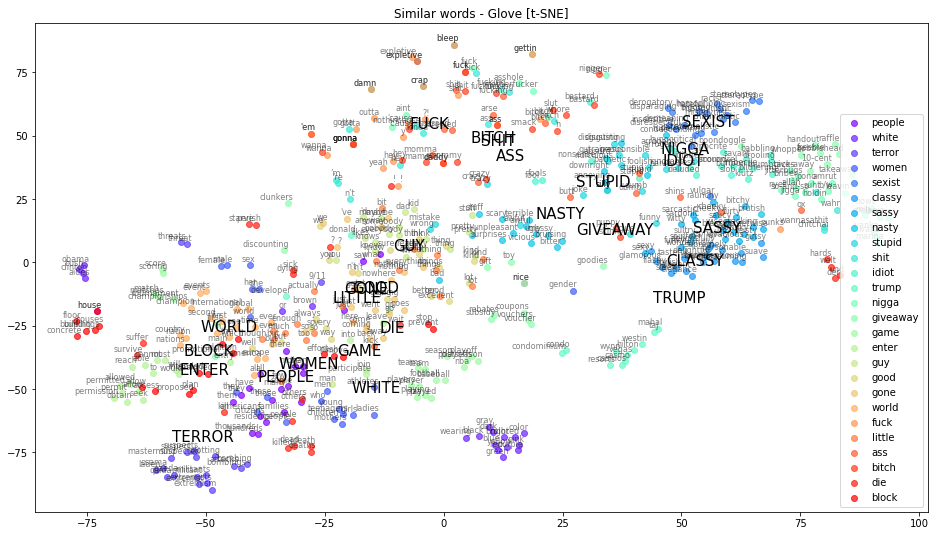

In [17]:
plotTSNE("Similar words - Glove [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - Glove - t-SNE.png")

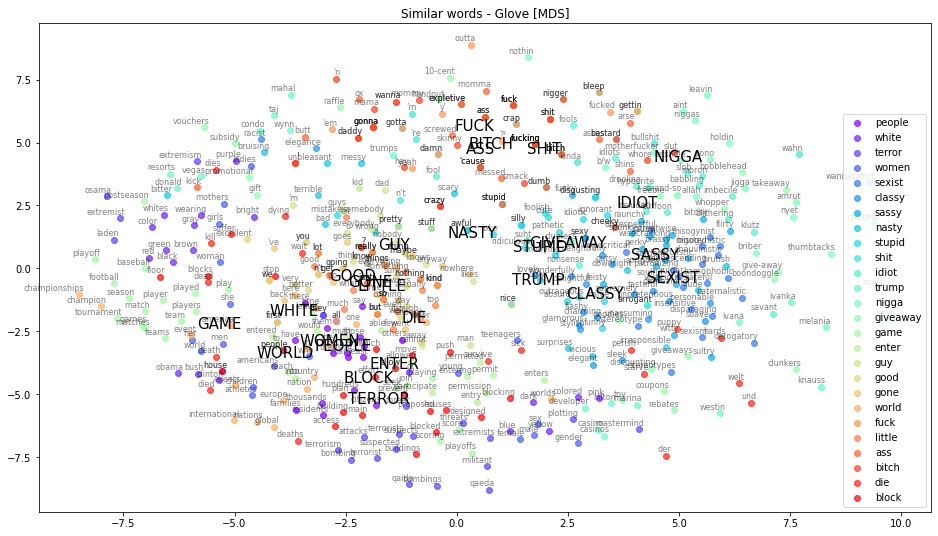

In [55]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "SimilarWords - Glove - MDS.png")

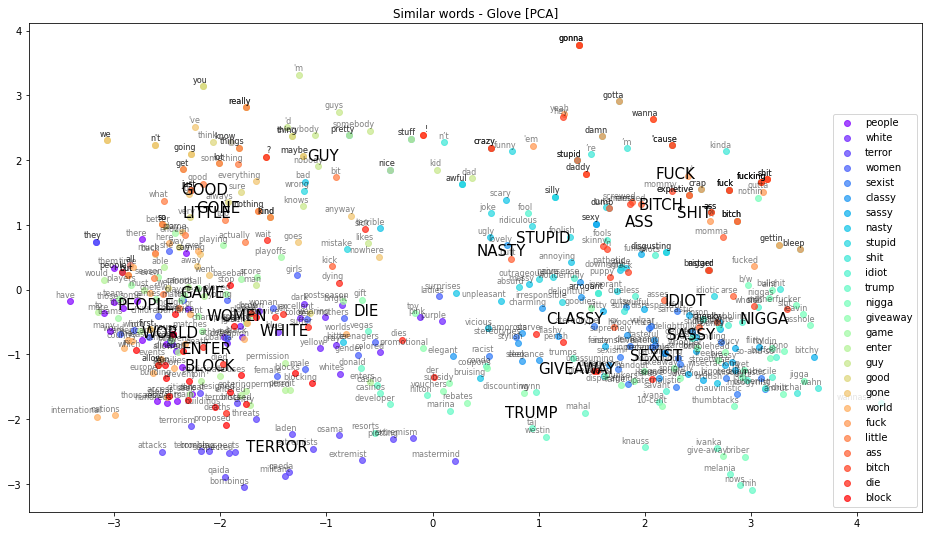

In [56]:
plotPCA("Similar words - Glove [PCA]", word_clusters, embedding_clusters, "SimilarWords - Glove - PCA.png")

## fasttext

In [18]:
# Run first time only to download model
import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')


In [ ]:
model_gn = load_facebook_vectors("cc.en.300.bin")

In [ ]:
TOP_N = 20
KEYS = { \
   "people": set(),
    "white": set(),
    "terror": set(),
    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "die": set(),
    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS